In [7]:
#This Cell Defines the parameters
import time
import cPickle as pickle
#import cv2
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from scipy.integrate import RK45
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.linear_model import LinearRegression

#Parameters
eta = 1.0					#Dispersion Parameter
n = 36						#Number of x-components
x_0 = np.ones(n)			#Initial x
x_0[0] = 0.99 
v_0 = x_0 					#v = x * (Integrating Factor). In this case IF = exp(eta*t), so IF(0) = 1 
sigma = 0.5					#SD of noise
S = np.zeros((n,n))			#covariance matrix for the noise
for i in xrange(4):
    S[i+1][i+1] = sigma 
h = 0.01					#Time step
h_range = np.arange(0.005, 0.025, 0.005)
t_final = 20.				#Terminal simulation time
nsteps = int(t_final / h)	#Number of steps
l = 0.8						#mixing parameter for the stratification algorithm
#Setup of Stratification
strata = [-0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75] 		#Boundary points of the strata in x_0 (or also later coordinates)
#n_strata_modes = 3    #Number of coordinates which will  be stratified
J = len(strata) + 1
#Initialize the collection of injection measures and weights
#The initial nu is a single point in each region, with weight 1
nu_0_points = []
nu_0_probs = []
for j in xrange(J-1):
	y = np.ones(n)
	y[0] = strata[j] - 0.1
	nu_0_points.append([y])
	nu_0_probs.append([1.])
y = np.ones(n)
y[0] = strata[J-2] + 0.1
nu_0_points.append([y])
nu_0_probs.append([1.])
#print np.array(nu_0_points)[0]
nu_0_weights = 1. / (len(strata) + 1.) * np.ones(len(strata) + 1)
n_exits = 20
n_iterations = 50
bin_edges = np.arange(-1., 1., 0.025)
bin_edges_later_vars = np.arange(-.3, .3, 0.0075)  #'later vars' refers to x_1,...,x_n. only x_0 has a direct source of noise, so the range it explores is different
bin_diff = 0.025
bin_diff_later_vars = 0.0075

In [8]:
#This Cell contains Definitions of the main functions

#The functions used in evaluating the IF Runge-Kutta step
#def f_IFRK(y, t): 
#	d = np.zeros(n)
#	d[0] = np.exp(-1.0 * eta * t) * (y[1] - y[n-2]) * y[n-1] #Note that the integrating factor's presence in e^(eta*t)N(e^-eta*t*v) has been simplified, and the linear part eliminated
#	d[1] = np.exp(-1.0 * eta * t) * (y[2] - y[n-1]) * y[0]
#	d[n-1] = np.exp(-1.0 * eta * t) * (y[0] - y[n-3]) * y[n-2]
#	for i in range(2, n-1):
#		d[i] = np.exp(-1.0 * eta * t) * (y[i+1] - y[i-2]) * y[i-1]
#	return d

#Alternate f - for a double well
#First version: double well in one coordinate
def f_IFRK(y, t):
	d = np.zeros(n)
	d[0] = np.exp(1.0 * eta * t) * (y[1] - y[n-2]) * y[n-1] - 8 * np.exp(2.0 * eta * t) * (y[0]**3) #Simplified IF form for double well in the first coordinate
	d[1] = np.exp(-1.0 * eta * t) * (y[2] - y[n-1]) * y[0]
	d[n-1] = np.exp(-1.0 * eta * t) * (y[0] - y[n-3]) * y[n-2]
	for i in range(2, n-1):
		d[i] = np.exp(-1.0 * eta * t) * (y[i+1] - y[i-2]) * y[i-1]
	return d

def g_IFRK(y, t): 
	noise = np.zeros(n)
	for i in xrange(n):
		noise[i] = S[i][i] * np.exp(eta * t)
	return noise
	

#The function that moves a stochastic system dX = fdt + gdW ahead by time h via Runge-Kutta
def RK_SDE_Step(y, t, f, g, h): 
	m = len(y)
	dW = np.random.normal(0.0, np.sqrt(h), m)
	b = np.random.binomial(1, 0.5)	#The binary RV used in the improved Euler RK method for sde's
	if b == 0:
		b = -1
	K_1 = h * f(y, t) + (dW - np.sqrt(h) * b) * g(y, t) 
	K_2 = h * f(y + K_1, t + h) + (dW + np.sqrt(h)*b) * g(y + K_1, t + h)
	y_new = y + 0.5 * (K_1 + K_2) 
	return y_new

#The Function that evolves the deterministic part of an SDE only by time h using RK4
def RK_4_Step(y, t, f, h):
	K_1 = h * f(y, t)
	K_2 = h * f(y + 0.5 * K_1, t + 0.5 * h)
	K_3 = h * f(y + 0.5 * K_2, t + 0.5 * h)
	K_4 = h * f(y + K_3, t + h)
	y_new = y + (1.0 / 6.0) * (K_1 + 2. * K_2 + 2. * K_3 + K_4)
	return y_new

#The test function to be used in the stratified algorithm
def phi(x):
	return np.sum(x[0]**2)


#This function uses the ones above to generate the data (x, t) of the system evolving in time for a given step size
def RK_SDE_Sim(y_0, nsteps, f, g, h):
	x = np.zeros((nsteps,n))
	x[0] = x_0
	v = x_0
	for i in  xrange(nsteps-1): 
		v = x[i]
		v = RK_SDE_Step(v, 0., f, g, h)
		x[i + 1] = np.exp(-1.0 * eta * h) * v 
	t_range = np.arange(0.0, t_final, h)
	return x, t_range

#This function evolves x and t similarly, but by using RK4 on the deterministic part of v, converting back to x, then adding the appropriate noise
def RK_4_Sim(x_0, nsteps, f, S, h, phi):
	m = len(x_0)
	mu_estimate = 0.0
	x = np.zeros((nsteps,n))
	x[0] = x_0
	v = x_0
	for i in  xrange(nsteps-1): 
		v = x[i]
		v = RK_4_Step(v, 0., f_IFRK, h)
		noise = np.zeros(m)
		for k in xrange(m):
			noise[k] = S[k][k] * np.sqrt((0.5/eta)*(1.-np.exp(-2.*eta*h))) * np.random.normal(0., 1.)
		x[i + 1] = np.exp(-1.0 * eta * h) * v + noise
		mu_estimate += phi(x[i+1]) / nsteps
		t_range = np.arange(0.0, t_final, h)
	return x, t_range, mu_estimate


################################

#Index function returning the current stratum
def idx(y, strata):
	if y[0] < strata[0]:
		return 0
	if y[0] >= strata[len(strata)-1]:
		return len(strata)
	for i in xrange(len(strata)-1):
		if strata[i] <= y[0] < strata[i+1]:
			return i + 1

###########
#Note: For now, the algorithm will just pick from nu_j with equal probability for all points, and will average the trajectories for each iteration for the final answer

#Draw a sample from the current j-th injection measure
def injection_draw(points, probs):
	num_choices = len(points)
	probs_sum = np.sum(np.array(probs))
	probs_normalized = probs
	for i in xrange(len(probs)):
		probs[i] = probs[i] / probs_sum
	index_chosen = np.random.choice(num_choices, p=probs_normalized)
	return points[index_chosen]

#Run from a starting measure until exiting, return the exit point and the trajectory the particle took
def RK_4_Sim_Exit(strata, nu_points, nu_probs, nu_weights, f, S, h):
	J = len(strata) + 1
	exit_points = []
	trajectory = []
	exit_times = np.zeros(J)
	for j in xrange(J):
		trajectory.append([])
	#we will record the histograms of x_0, x_1 and x_15, and the joint histograms of (x_0, x_1), (x_0, x_15), and (x_1, x_15)
	trajectory_hist = [[],[],[],[],[],[]]
	trajectory_hist[0] = np.histogram([], bins=bin_edges, weights=np.ones(len(trajectory[0])))
	trajectory_hist[1] = np.histogram([], bins=bin_edges, weights=np.ones(len(trajectory[0])))
	trajectory_hist[2] = np.histogram([], bins=bin_edges_later_vars, weights=np.ones(len(trajectory[0])))
	trajectory_hist[3] = np.histogram2d([],[], bins=(bin_edges,bin_edges))
	trajectory_hist[4] = np.histogram2d([],[], bins=(bin_edges,bin_edges_later_vars))
	trajectory_hist[5] = np.histogram2d([],[], bins=(bin_edges_later_vars,bin_edges_later_vars))
	H = [[],[],[],[],[],[]]
	for i in xrange(6):
		H[i] = trajectory_hist[i][0]
	for j in xrange(J):
		prob_sum = np.sum(nu_probs[j])
		if prob_sum <= 1.e-8 :
			nu_points[j] = nu_0_points[j]
			nu_probs[j] = np.ones(len(nu_0_points[j]))
		start_point = injection_draw(nu_points[j], nu_probs[j])
		idx_0 = idx(start_point, strata)
		current_idx = idx_0
		x_current = start_point
		while (current_idx == idx_0):
			trajectory[j].append(x_current)
			H[0] = H[0] + np.histogram([x_current[0]], bins=bin_edges, weights = [nu_weights[j]])[0]
			H[1] = H[1] + np.histogram([x_current[1]], bins=bin_edges, weights = [nu_weights[j]])[0]
			H[2] = H[2] +  np.histogram([x_current[19]], bins=bin_edges_later_vars, weights = [nu_weights[j]])[0]
			H[3] = H[3] + np.histogram2d([x_current[0]], [x_current[1]], bins=(bin_edges, bin_edges))[0] * nu_weights[j]
			H[5] = H[5] + np.histogram2d([x_current[4]], [x_current[19]], bins=(bin_edges_later_vars, bin_edges_later_vars))[0] * nu_weights[j]
			H[4] = H[4] + np.histogram2d([x_current[0]], [x_current[19]], bins=(bin_edges, bin_edges_later_vars))[0] * nu_weights[j]
			#compute the next step
			v = x_current
			v = RK_4_Step(v, 0., f_IFRK, h)
			noise = np.zeros(len(v))
			for k in xrange(len(v)):
				noise[k] = S[k][k] * np.sqrt((0.5/eta)*(1.-np.exp(-2.*eta*h))) * np.random.normal(0., 1.)
			x_current = np.exp(-1.0 * eta * h) * v + noise
			#Update the index so the next loop checks if an exit has occurred
			current_idx = idx(x_current, strata)
			exit_times[j] += 1
		exit_points.append(x_current)
	trajectory_hist = (H, bin_edges, bin_edges_later_vars)
	return exit_points, trajectory, exit_times, trajectory_hist


#Note: For now at least, the iteration will just run for n_exits excursions in each stratum, so that the number of exit points is controlled. This can be changed later
def RK_4_stratified_iteration(n_exits, strata, nu_points, nu_probs, nu_weights, f, S, h):
	nu_points_next = []
	nu_probs_next = []
	time_spent = np.zeros(J)
	for j in xrange(J):
		nu_points_next.append([])
		nu_probs_next.append([])
	nu_weights_next = np.zeros(J)
	iteration_hist = [[],[],[],[],[],[]]
	iteration_hist[0] = np.histogram([], bins=bin_edges, weights=np.ones(len([])))
	iteration_hist[1] = np.histogram([], bins=bin_edges, weights=np.ones(len([])))
	iteration_hist[2] = np.histogram([], bins=bin_edges_later_vars, weights=np.ones(len([])))
	iteration_hist[3] = np.histogram2d([],[], bins=[bin_edges,bin_edges])
	iteration_hist[4] = np.histogram2d([],[], bins=[bin_edges,bin_edges_later_vars])
	iteration_hist[5] = np.histogram2d([],[], bins=[bin_edges_later_vars,bin_edges_later_vars])
	H = [[],[],[],[],[],[]]
	for i in xrange(6):
		H[i] = iteration_hist[i][0]
	G = np.zeros((J,J))
	for i in xrange(n_exits):
		exit_points, trajectory, exit_times, trajectory_hist = RK_4_Sim_Exit(strata, nu_points, nu_probs, nu_weights, f, S, h)
		for j in xrange(J):
			exit_idx = idx(exit_points[j], strata)
			nu_points_next[exit_idx].append(exit_points[j])
			nu_probs_next[exit_idx].append(nu_weights[j])
			G[j][exit_idx] += 1.
			time_spent += exit_times
		for k in xrange(6):
			H[k] += trajectory_hist[0][k]
	#If nu_points_next is empty for some j, replace it with a single point
	for j in xrange(J):
		if len(nu_points_next[j]) == 0:
			nu_points_next[j].append(nu_0_points[j][0])
			nu_probs_next[j].append(1.)
	#Normalize G and compute the weights
	for i in xrange(J):
		row_sum = np.sum(G[i])
		for j in xrange(J):
			G[i][j] = G[i][j] / row_sum
			nu_weights_next[j] += G[i][j] * nu_weights[i]
    
	#Compile the histograms over each excursion
	iteration_hist = (H, bin_edges, bin_edges_later_vars)
	return nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent

#New function - eigenvector version
def RK_4_stratified_iteration_eig(n_exits, strata, nu_points, nu_probs, nu_weights, f, S, h):
	nu_points_next = []
	nu_probs_next = []
	xi_points = []
	occupation = []    #The list of points in each excursion, for forming the occupation measure
	for j in xrange(J):
		nu_points_next.append([])
		nu_probs_next.append([])
		xi_points.append([])
	time_spent = np.zeros(J)
	nu_weights_next = np.zeros(J)
	iteration_hist = [[],[],[],[],[],[]]
	iteration_hist[0] = np.histogram([], bins=bin_edges, weights=np.ones(len([])))
	iteration_hist[1] = np.histogram([], bins=bin_edges, weights=np.ones(len([])))
	iteration_hist[2] = np.histogram([], bins=bin_edges_later_vars, weights=np.ones(len([])))
	iteration_hist[3] = np.histogram2d([],[], bins=[bin_edges,bin_edges])
	iteration_hist[4] = np.histogram2d([],[], bins=[bin_edges,bin_edges_later_vars])
	iteration_hist[5] = np.histogram2d([],[], bins=[bin_edges_later_vars,bin_edges_later_vars])
	H = [[],[],[],[],[],[]]
	for i in xrange(6):
		H[i] = iteration_hist[i][0]
	G = np.zeros((J,J))
	for i in xrange(n_exits):
		exit_points, trajectory, exit_times, trajectory_hist = RK_4_Sim_Exit(strata, nu_points, nu_probs, nu_weights, f, S, h)
		for j in xrange(J):
			exit_idx = idx(exit_points[j], strata)
			xi_points[j].append([exit_points[j], exit_idx])
			G[j][exit_idx] += 1.
			time_spent += exit_times
		occupation.append(trajectory)
	#If nu_points_next is empty for some j, replace it with a single point
	#Normalize G and compute the weights
	for i in xrange(J):
		row_sum = np.sum(G[i])
		for j in xrange(J):
			G[i][j] = G[i][j] / row_sum
			nu_weights_next[j] += G[i][j] * nu_weights[i]
    
    #Compute the weights for the eigenvector version
#	evals, evecs = np.linalg.eig(G.T)
#	evec1 = evecs[:,np.isclose(evals, 1)]
#	evec1 = evec1[:,0]
#	nu_weights_next = evec1 / evec1.sum()
    
    #Option - Just use a high power of G instead of the eig function
	for k in xrange(100*J):
		nu_weights_next = np.dot(nu_weights, G)
	nu_weights_next = nu_weights_next / np.sum(nu_weights_next)
    
    #Form the histogram of the occupation measure with the newly calculated weights
	for k in xrange(n_exits):
		for j in xrange(J):
			for i in xrange(len(occupation[k][j])):
				x_point = occupation[k][j][i]
				H[0] = H[0] + np.histogram([x_point[0]], bins=bin_edges, weights = [nu_weights_next[j]])[0]
				H[1] = H[1] + np.histogram([x_point[1]], bins=bin_edges, weights = [nu_weights_next[j]])[0]
				H[2] = H[2] +  np.histogram([x_point[19]], bins=bin_edges_later_vars, weights = [nu_weights_next[j]])[0]
				H[3] = H[3] + np.histogram2d([x_point[0]], [x_point[1]], bins=(bin_edges, bin_edges))[0] * nu_weights_next[j]
				H[5] = H[5] + np.histogram2d([x_point[4]], [x_point[19]], bins=(bin_edges_later_vars, bin_edges_later_vars))[0] * nu_weights_next[j]
				H[4] = H[4] + np.histogram2d([x_point[0]], [x_point[19]], bins=(bin_edges, bin_edges_later_vars))[0] * nu_weights_next[j]

    
    #Build the new injection measures from xi and nu_weights_next
	for j in xrange(J):
		for i in xrange(n_exits):
			exit_point = xi_points[j][i][0]
			exit_idx = xi_points[j][i][1]
			nu_points_next[exit_idx].append(exit_point)
			nu_probs_next[exit_idx].append(nu_weights_next[j])
            
	for j in xrange(J):
		if len(nu_points_next[j]) == 0:
			nu_points_next[j].append(nu_0_points[j][0])
			nu_probs_next[j].append(1.)
            
    
	#Compile the histograms over each excursion
	iteration_hist = (H, bin_edges, bin_edges_later_vars)
	return nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent

def RK_4_Stratified(n_iterations, n_exits, strata, nu_points, nu_probs, nu_weights, f, S, h, l):
	nu_points_next, nu_probs_next, nu_weights_next, iteration_hist = RK_4_stratified_iteration(n_exits, strata, nu_points, nu_probs, nu_weights, f_IFRK, S, h)
	H = iteration_hist[0]
	for i in xrange(n_iterations-1):
		nu_points_next, nu_probs_next, nu_weights_next, iteration_hist = RK_4_stratified_iteration(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f, S, h)
		#H = (1. - l) * H + l * iteration_hist[0]
		H += iteration_hist[0]		#Option: Simply average the histogram of all iterations with equal weight, not using lambda (l)
	#Finally, Normalize H so it is a density
	H_sum = 1. * np.sum(H)
	for i in xrange(len(H)):
		H[i] = H[i] / H_sum
	stratified_hist = (H, bin_edges)
	return nu_points_next, nu_probs_next, nu_weights_next, stratified_hist

def TV_dist(hist_1, hist_2):
    l = len(hist_1)
    d = 0.
    for i in xrange(l):
        d += abs(hist_1[i]-hist_2[i]) * bin_diff
    d = d / 2.
    return d

In [3]:
#This cell contains the code (commented by default) for testing and plots

#Test Plot, unstratified
#x, t_range, mu_estimate_unstratified = RK_4_Sim(x_0, nsteps, f_IFRK, S, h, phi)
#un_stratified_hist = np.histogram(x[:,0], bins=bin_edges, density=True)
#H = un_stratified_hist[0]
#H_sum = np.sum(H)
#for i in xrange(len(H)):
#	H[i] = H[i] / H_sum
#un_stratified_hist = (H, bin_edges)
#plt.plot(un_stratified_hist[1][1:], un_stratified_hist[0])
#plt.show()

#Test for a single excursion starting in each stratum
#exit_points, trajectory, exit_times, trajectory_hist = RK_4_Sim_Exit(strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#for j in xrange(J):
#	plt.plot(np.array(trajectory[j])[:,0], xrange(len(trajectory[j])), 'o')
#plt.show()
#plt.plot(trajectory_hist[2][1:], trajectory_hist[0][1], 'o')
#plt.show()


#Iteration_Test
#Optional - Compute some iterations then plot the last one
#Optional - Use the eig version
#n_exits = 20
#n_iterations = 100
#strata = [-0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75] 		#Boundary points of the strata in x_0
#J = len(strata) + 1
#h = 0.025
#nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration_eig(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#for i in xrange(n_iterations):
#    nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration_eig(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f_IFRK, S, h)
#    plt.plot(xrange(8), nu_weights_next, 'bo')
#    plt.show()
    
#    raw_input("Press Enter to continue...")

#stratified_mixed_hist = []
#nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#hist = iteration_hist[0][0]

#for i in xrange(n_exits):
#    nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f_IFRK, S, h)
#    hist = hist + iteration_hist[0][0]
#    H = hist / (i + 2.)
    #hist = hist / (np.sum(hist) * bin_diff)
#    
#    plt.plot(bin_edges[1:], hist,'o')
#    plt.show()
#    raw_input("Press Enter to continue...")

#for j in xrange(J):
#	plt.hist(np.array(nu_points_next[j])[:,0], bins=bin_edges, weights=np.array(nu_probs_next[j]))
#plt.plot(xrange(J), nu_weights_next)
#plt.plot(iteration_hist[1][1:], iteration_hist[0][0], 'o')
#plt.show()
#iteration_hist[0][3]

#Iteration test - eig version

#Stratified Algorithm Test
#for s in xrange(4):
#	nu_points_next, nu_probs_next, nu_weights_next, stratified_hist = RK_4_Stratified(n_iterations * (s+1), n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h, l)
#	plt.plot(stratified_hist[1][1:], stratified_hist[0])
#plt.show()

In [65]:
#This Cell will compute and store the main data from a run of the un-stratified algorithm
h = 0.005
t_final = 5000
nsteps = int(t_final / h)
r = nsteps / 1000
un_stratified_data = []
print 0
x, t_range, mu_estimate_unstratified = RK_4_Sim(x_0, r, f_IFRK, S, h, phi)
un_stratified_hist = np.histogram(x[:,0], bins=bin_edges, density=True)
un_stratified_data.append([un_stratified_hist, bin_edges])
for k in xrange(999):
    print k + 1
    x, t_range, mu_estimate_unstratified = RK_4_Sim(x[r-1], r, f_IFRK, S, h, phi)
    un_stratified_hist = np.histogram(x[:,0], bins=bin_edges, density=True)
    un_stratified_data.append([un_stratified_hist, bin_edges])
with open("un_strat_hist_double_well.dat", "wb") as f:
    pickle.dump(un_stratified_data, f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [170]:
#This Cell will compute and store the main data from a run of the stratified algorithm, for both versions
#stratified_data_eig_comparison = []
#J_range = np.arange(10,55,5)
#n_exits = 50
#n_iterations = 100
#stratified_data = []
#for n_strata in J_range:
#    J = n_strata
#    print J
#    strata = [-1. + (2.* (j+1.) / J) for j in xrange(J-1)]
#    nu_0_points = []
#    nu_0_probs = []
#    for j in xrange(J-1):
#        y = np.ones(n)
#        y[0] = strata[j] - (1. / J)
#        nu_0_points.append([y])
#        nu_0_probs.append([1.])
#    y = np.ones(n)
#    y[0] = strata[J-2] + (1. / J)
#    nu_0_points.append([y])
#    nu_0_probs.append([1.])
#    nu_0_weights = (1. / J) * np.ones(J)
#    h = (2. / J) * 0.05
#    data_current_J = []
    
#    nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#    data_current_J.append([nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent])
    
#    nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, iteration_hist_eig, time_spent_eig = RK_4_stratified_iteration_eig(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#    data_current_J.append([nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, iteration_hist_eig, time_spent_eig])
    
#    for i in xrange(n_iterations):
#        print i + 1
#        nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f_IFRK, S, h)
#        data_current_J.append([nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent])
            
#        nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, iteration_hist_eig, time_spent_eig = RK_4_stratified_iteration_eig(n_exits, strata, nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, f_IFRK, S, h)
#        data_current_J.append([nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, iteration_hist_eig, time_spent_eig])
    
#    stratified_data.append(data_current_J)
#with open("strat_alg_lorenz_96_4_noise_eig_comparison", "wb") as f:
#    pickle.dump(stratified_data, f)

In [39]:
#Load the un-stratified algorithm data
with open("un_strat_hist_double_well.dat", "rb") as f:   #Correction: It is not every 1000 steps, but 5,000,000 steps divided into 1000, so every 5000 steps
    un_stratified_data = pickle.load(f)
#h = 0.01, histogram every 5000 steps, 5000000 steps total, so 1000 histograms

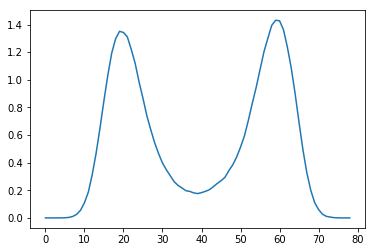

In [41]:
#This cell is for testing the data from the un-stratified algorithm
hist_sum_un_strat = np.zeros((1000,79))
hist_avg_un_strat = np.zeros((1000,79))
hist_un_strat = np.zeros((1000,79))
for i in xrange(1000):
    hist_sum_un_strat += np.array(un_stratified_data[i][0][0])
    hist_un_strat[i] = np.array(un_stratified_data[i][0][0])
    hist_un_strat[i] = hist_un_strat[i]/ (np.sum(hist_un_strat[i])* bin_diff)
    hist_avg_un_strat[i] = hist_sum_un_strat[i] / (np.sum(hist_sum_un_strat[i]) * bin_diff)
#    plt.plot(bin_edges[1:], hist_sum_un_strat[i] / (i + 1.), 'o')
#    plt.show()
#    raw_input("Press Enter to continue...")
#plt.plot(xrange(500), [np.log(TV_dist(hist_avg_un_strat[i],hist_avg_un_strat[999])) for i in xrange(500)])
#plt.plot(np.log(xrange(999)), [np.log(TV_dist(hist_avg_un_strat[i],hist_avg_un_strat[i+1])) for i in xrange(999)])
#plt.plot(xrange(999), [TV_dist(hist_un_strat[i],hist_un_strat[i+1]) for i in xrange(999)])
plt.plot(np.arange(79), hist_avg_un_strat[999])
plt.show()

#Note: Compute the transition matrix over the un-stratified run, and use those as the 'true' weights in the next graph

In [11]:
#Load the stratified algorithm data
#with open("strat_alg_lorenz_96_16_noise.dat", "rb") as f:
#    stratified_data_16 = pickle.load(f)
#Load the stratified algorithm data
#with open("strat_alg_lorenz_96_4_noise_2.dat", "rb") as f:
#    stratified_data_4_2 = pickle.load(f)
with open("strat_alg_lorenz_96_4_noise_eig_comparison", "rb") as f:  #h changes with J, h = 0.1 * wdidth of strata
    stratified_data_4_comparison_eig = pickle.load(f)
#with open("strat_alg_lorenz_96_4_noise_J_10_2000.dat", "rb") as f:   #h=0.01, n_exits = 50, n_iterations = 2000
#    stratified_data_4_comparison_10 = pickle.load(f)

In [8]:
with open("strat_alg_lorenz_96_4_noise_nexits_comparison.dat", "rb") as f:
    stratified_data_4_nexits_comparison = pickle.load(f)
#h=0.005 (constant), J = 10, n_exits_range = np.arange(100,160,10), n_iterations = 500

In [42]:
with open("strat_alg_lorenz_96_4_noise_J_comparison_1.dat", "rb") as f:
    stratified_data_4_J_comparison_1 = pickle.load(f)
#h=0.005 (constant), J_range = np.arange(10,40,10), n_exits = 150, n_iterations = 500

IOError: [Errno 2] No such file or directory: 'strat_alg_lorenz_96_4_noise_J_comparison_1.dat'

In [172]:
#stratified_data = stratified_data_4_comparison
#stratified_mixed_hist = []
#stratified_mixed_weights = []
#fig = plt.figure()
#ax = Axes3D(fig)

#hist_number = 0      #Indicates which distribution, or joint distribution, is to be extracted from the data
#for m in xrange(300):
    #ax.clear()
#    weights = stratified_data[1][0][2] / (m+1.)
#    hist = stratified_data[0][0][3][0][hist_number] / (m+1.)
#    for i in xrange(m):
#        weights += stratified_data[1][i][2] / (m+1.)
#        hist += stratified_data[0][i+1][3][0][hist_number] / (m+1.)
#    hist = hist / (np.sum(hist) * bin_diff)
#    stratified_mixed_hist.append(hist)
#    stratified_mixed_weights.append(weights)
    
    #ax.plot_surface(bin_edges[1:], bin_edges_later_vars[1:], stratified_mixed_hist[m])
#    plt.plot(bin_edges[1:], stratified_mixed_hist[m],'o')
#    plt.show()
    #raw_input("Press Enter to continue...")

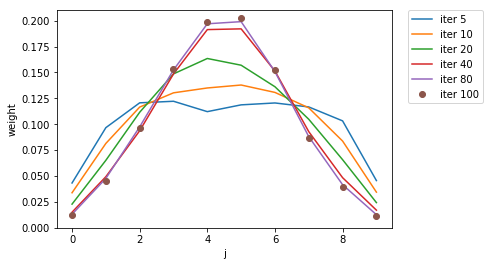

In [14]:
#Comparing the convergence of nu_tot for the basic and eig versions
stratified_data = stratified_data_4_comparison_eig[0]

weights_sum = (1. / 10.) * np.ones((100, 10))   #weights_sum[k] will be the sum of the first k weight vectors
weights_sum_eig = (1. / 10.) * np.ones((100,10))
for k in xrange(99):
    weights_sum[k+1] = weights_sum[k] + np.array(stratified_data[2*k][2])
    weights_sum_eig[k+1] = weights_sum_eig[k] + np.array(stratified_data[2*k+1][2])
#    w=weights/(k+1.)
#    plt.plot(xrange(10), w, 'bo')
#    plt.show()
    
#    raw_input("Press Enter to continue...")

m = 5
#weights_final = weights_sum[99] / 100.
weights_final = weights_sum_eig[99] / 100.
for k in xrange(5):
    r = m * (2**k)
    #plt.plot(xrange(10), weights_sum[r] / (r + 1.), label = 'iter ' + str(r))
    plt.plot(xrange(10), weights_sum_eig[r] / (r + 1.), label = 'iter ' + str(r))
    plt.ylim(0.,0.21)
    plt.xlabel('j')
    plt.ylabel('weight')
plt.plot(xrange(10), weights_final, 'o', label='iter 100')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#for k in xrange(50):
#Try: Series of basis functions
#Try: TV distance of histograms
#Try: Indicator functions on strata

#For different J, Try: Plot log(TV-distance), using histograms, as a line with negative slope, with time as the x-axis, and plot the lines for several J on the same graph

plt.show()

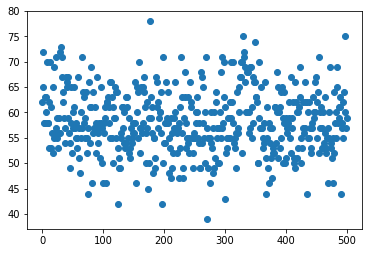

In [10]:
#Plot heat maps in some well converging strata and some"problem" strata
#Plot the number of exits into each stratum over time
stratified_data_1D = stratified_data_4_J_comparison_1[2]
n_iterations = len(stratified_data_1D) / 2

n_exits_in_eig = np.zeros((n_iterations, J))
for i in xrange(n_iterations):
    nu_points = stratified_data_1D[2 * i + 1][0]
    for j in xrange(J):
        n_exits_in_eig[i][j] = len(nu_points[j])

min_points = [np.amin(n_exits_in_eig[i]) for i in xrange(n_iterations)]
plt.plot(xrange(n_iterations), min_points, 'o')
plt.show()

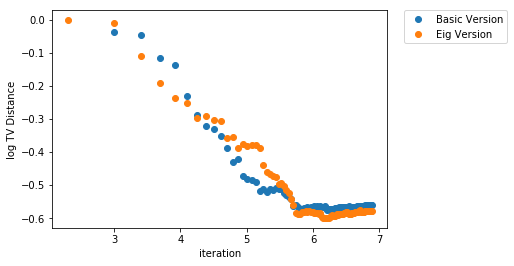

In [37]:
stratified_data = stratified_data_4_comparison_eig[0]
#un_strat_hist = np.array(un_stratified_data[0])
#un_strat_hist[0] = un_strat_hist[0] / (np.sum(un_strat_hist[0])* bin_diff)
J = 10
q = 100

hist_sum = np.zeros(79)
hist_sum_eig = []

hist_avg = np.zeros((q,79))
hist_avg_eig = np.zeros((q,79))

hist_avg[0] = np.histogram((stratified_data[0][3][0][0]),bins=bin_edges)[0]
hist_avg_eig[0] = np.histogram((stratified_data[1][3][0][0]),bins=bin_edges)[0]

for k in xrange(q-1):
    hist_avg[k+1] = hist_avg[k] + np.histogram((stratified_data[2*k][3][0][0]),bins=bin_edges)[0]
    hist_avg_eig[k+1] = hist_avg_eig[k] + np.histogram((stratified_data[2*k+1][3][0][0]),bins=bin_edges)[0]
    
for k in xrange(q):
    hist_avg[k] = hist_avg[k] / (np.sum(hist_avg[k]) * bin_diff)
    hist_avg_eig[k] = hist_avg_eig[k] / (np.sum(hist_avg_eig[k]) * bin_diff)

m = 5
for k in xrange(5):
    r = m * (2**k)
    #plt.plot(bin_edges[1:], hist_avg[r])
    #plt.plot(bin_edges[1:], hist_avg_eig[r])
#plt.plot(bin_edges[1:], un_strat_hist[0])

un_strat_hist = un_stratified_data[0][0]
un_strat_hist = un_strat_hist / (np.sum(un_strat_hist) * bin_diff)

s = q-1
un_strat_end_time = 999
plt.plot(np.log(10 *np.array(xrange(s))), [np.log(TV_dist(un_strat_hist, hist_avg[1 * k])) for k in xrange(s)], 'o', label = 'Basic Version')
#Remember to label correctly
plt.plot(np.log(10 * np.array(xrange(s))), [np.log(TV_dist(un_strat_hist, hist_avg_eig[1 * k])) for k in xrange(s)], 'o', label = 'Eig Version')
plt.xlabel('iteration')
plt.ylabel('log TV Distance')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#Consider the ppossibility that the un-stratified histogram is actually less accurate after some time

plt.show()
#Addapt to lorenz 63 and to 2(n)-dim strata

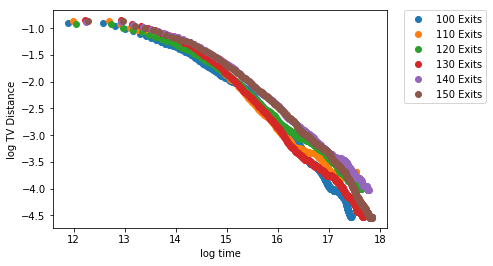

In [37]:
#This cell generates a graph for comparing performance across different values of J. 
iter_times = np.zeros((6,500))
iter_times_eig = np.zeros((6,500))
J = 10
for j in xrange(6):
    J = 10 + 10 * j
    n_exits = 100+10*j
    stratified_data = stratified_data_4_nexits_comparison[j]
    un_strat_hist = un_stratified_data[0]

    hist_sum = np.zeros(79)
    hist_sum_eig = []

    hist_avg = np.zeros((500,79))
    hist_avg_eig = np.zeros((500,79))

    hist_avg[0] = stratified_data[0][3][0][0]
    hist_avg_eig[0] = stratified_data[1][3][0][0]

    for k in xrange(499):
        hist_avg[k+1] = hist_avg[k] + np.array(stratified_data[2*k][3][0][0])
        hist_avg_eig[k+1] = hist_avg_eig[k] + np.array(stratified_data[2*k+1][3][0][0])
    
    for k in xrange(500):
        hist_avg[k] = hist_avg[k] / (np.sum(hist_avg[k]) * bin_diff)
        hist_avg_eig[k] = hist_avg_eig[k] / (np.sum(hist_avg_eig[k]) * bin_diff)
    
    iter_times[j][0] = np.sum(np.array(stratified_data[0][4]))
    iter_times_eig[j][0] = np.sum(np.array(stratified_data[1][4]))
    for k in xrange(499):
        iter_times[j][k+1] = iter_times[j][k] + np.sum(np.array(stratified_data[2*k][4]))
        iter_times_eig[j][k+1] = iter_times_eig[j][k] + np.sum(np.array(stratified_data[2*k+1][4]))
    
    m = 1
    l = 500
    #plt.plot(np.log(m * np.array(xrange(l))), [np.log(TV_dist(hist_avg_un_strat[999], hist_avg[m * k])) for k in xrange(l)], 'o', label = 'J=' + str(J))
    #plt.plot(np.log(m * np.array(xrange(l))), [np.log(TV_dist(hist_avg_un_strat[999], hist_avg_eig[m * k])) for k in xrange(l)], 'o', label = 'J=' + str(J))
    #plt.xlabel('log iter')
    plt.plot(np.log(iter_times[j]), [np.log(TV_dist(hist_avg_un_strat[999], hist_avg[m * k])) for k in xrange(l)], 'o', label = str(n_exits) + ' Exits')
    #plt.plot(np.log(iter_times[j]), [np.log(TV_dist(hist_avg_un_strat[999], hist_avg_eig[m * k])) for k in xrange(l)], 'o', label = str(n_exits) + ' Exits')
    plt.xlabel('log time')
    plt.ylabel('log TV Distance')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #Note that the 'elbow' seems to happen at the same time for all J. 
plt.show()

#On each iteration, calculate the expected time to exit, make h small enough and keep it constnat for all J
#Plot log TV distance vs. average exit time for each iteration

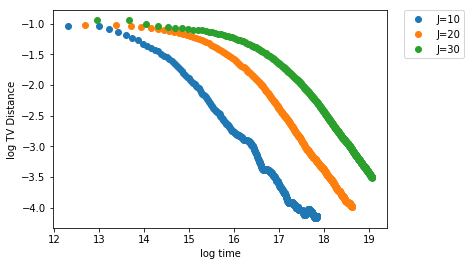

In [32]:
#This cell generates a graph for comparing performance across different values of J. 
iter_times = np.zeros((3,500))
iter_times_eig = np.zeros((3,500))
for j in xrange(3):
    J = 10 + 10 * j
    stratified_data = stratified_data_4_J_comparison_1[j]
    un_strat_hist = un_stratified_data[0]

    hist_sum = np.zeros(79)
    hist_sum_eig = []

    hist_avg = np.zeros((500,79))
    hist_avg_eig = np.zeros((500,79))

    hist_avg[0] = stratified_data[0][3][0][0]
    hist_avg_eig[0] = stratified_data[1][3][0][0]

    for k in xrange(499):
        hist_avg[k+1] = hist_avg[k] + np.array(stratified_data[2*k][3][0][0])
        hist_avg_eig[k+1] = hist_avg_eig[k] + np.array(stratified_data[2*k+1][3][0][0])
    
    for k in xrange(500):
        hist_avg[k] = hist_avg[k] / (np.sum(hist_avg[k]) * bin_diff)
        hist_avg_eig[k] = hist_avg_eig[k] / (np.sum(hist_avg_eig[k]) * bin_diff)
    
    iter_times[j][0] = np.sum(np.array(stratified_data[0][4]))
    iter_times_eig[j][0] = np.sum(np.array(stratified_data[1][4]))
    for k in xrange(499):
        iter_times[j][k+1] = iter_times[j][k] + np.sum(np.array(stratified_data[2*k][4]))
        iter_times_eig[j][k+1] = iter_times_eig[j][k] + np.sum(np.array(stratified_data[2*k+1][4]))
    
    m = 1
    l = 500
    #plt.plot(np.log(m * np.array(xrange(l))), [np.log(TV_dist(hist_avg_un_strat[999], hist_avg[m * k])) for k in xrange(l)], 'o', label = 'J=' + str(J))
    #plt.plot(np.log(m * np.array(xrange(l))), [np.log(TV_dist(hist_avg_un_strat[999], hist_avg_eig[m * k])) for k in xrange(l)], 'o', label = 'J=' + str(J))
    #plt.xlabel('log iter')
    #plt.plot(np.log(iter_times[j]), [np.log(TV_dist(hist_avg_un_strat[999], hist_avg[m * k])) for k in xrange(l)], 'o', label = 'J=' + str(J))
    plt.plot(np.log(iter_times_eig[j]), [np.log(TV_dist(hist_avg_un_strat[999], hist_avg_eig[m * k])) for k in xrange(l)], 'o', label = 'J=' + str(J))
    plt.xlabel('log time')
    plt.ylabel('log TV Distance')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #Note that the 'elbow' seems to happen at the same time for all J. 
plt.show()

#On each iteration, calculate the expected time to exit, make h small enough and keep it constnat for all J
#Plot log TV distance vs. average exit time for each iteration

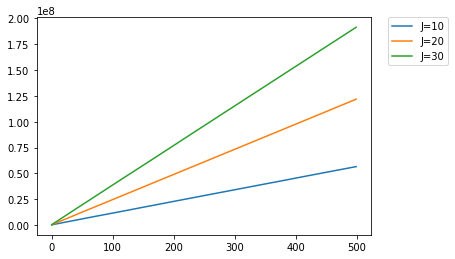

In [30]:
for j in xrange(3):
    J = 10+10*j
    #plt.plot(xrange(500), iter_times[j], label = 'J=' + str(J))
    plt.plot(xrange(500), iter_times_eig[j], label = 'J=' + str(J))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [94]:
#weights = [.125, .125, .125, .125, .125, .125, .125, .125]
#for m in xrange(300):
#    weights += stratified_data[1][m][2] 
#    w=weights/(m+1.)
#    plt.plot(xrange(8), w, 'o')
#    plt.show()
#    
#    raw_input("Press Enter to continue...")

In [8]:
#This cell is for testing the creating of a movie with moviepy.editor.VideoClip and a make_frame function
#note: t ranges from 0 to duration, in increments of 1/fps. Make sure that it lines up with the number of plots to be used,
#So that you can call a new iteration of the algorithm for each new frame. E.g. here, duration = 3 and fps=10, and t_range
#has 30 values, so the video goes through all 30 plots in 3 seconds. 
t_range = np.arange(0.0, 3.0, 0.1)

duration = 3
fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    x = bin_edges[1:]
    t_current = t_range[int(t * 10)]
    ax.plot(x, t_current * x**2, 'o')
    ax.set_ylim(0.0, 3.0)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.ipython_display(fps=int(len(t_range) / duration), loop=True, autoplay=True)

Text(0.5,0,'z')

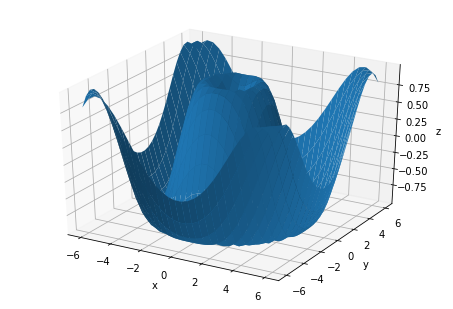

In [2]:
#Test for 3d plotting
fig = plt.figure()

ax = Axes3D(fig)
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)
ax.plot_surface(X, Y, Z)
#ax.scatter(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


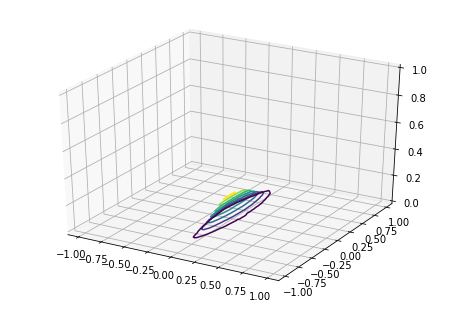

In [13]:
#Create video of 3d plots from the stratified data
#Joint Distribution of X_0, X_1 for 4 noise

duration = 29.9
#fig, ax = plt.subplots()
fig = plt.figure()
ax = Axes3D(fig)
def make_frame(t):
    ax.clear()
    m = int(t * 10)
    ax.contour3D(bin_edges[1:], bin_edges[1:], stratified_mixed_hist[m])
    #ax.plot(bin_edges[1:], stratified_mixed_hist[m], 'o')
    ax.set_zlim(0.0, 1.0)
    #ax.set_ylim(0.0, 1.7)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.ipython_display(fps=10, loop=True, autoplay=True)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4




t:  90%|████████▉ | 268/299 [00:32<00:03,  9.15it/s, now=None]


t: 100%|██████████| 299/299 [00:36<00:00,  8.61it/s, now=None]
                                                              

Moviepy - Done !
Moviepy - video ready __temp__.mp4


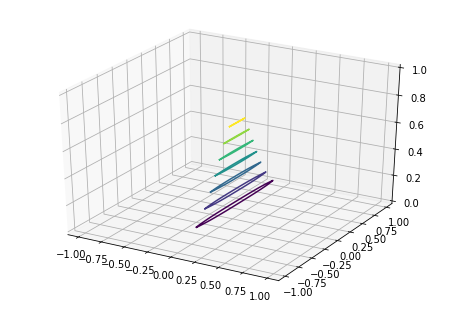

In [90]:
#Create video of 3d plots from the stratified data
#Joint Distribution of X_0, X_19 for 4 noise

duration = 29.9
#fig, ax = plt.subplots()
fig = plt.figure()
ax = Axes3D(fig)
def make_frame(t):
    ax.clear()
    m = int(t * 10)
    ax.contour3D(bin_edges[1:], bin_edges[1:], stratified_mixed_hist[m])
    #ax.plot(bin_edges[1:], stratified_mixed_hist[m], 'o')
    ax.set_zlim(0.0, 1.0)
    #ax.set_ylim(0.0, 1.7)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.ipython_display(fps=10, loop=True, autoplay=True)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4




t:  88%|████████▊ | 262/299 [00:34<00:04,  8.35it/s, now=None]


t: 100%|██████████| 299/299 [00:38<00:00,  8.75it/s, now=None]
                                                              

Moviepy - Done !
Moviepy - video ready __temp__.mp4


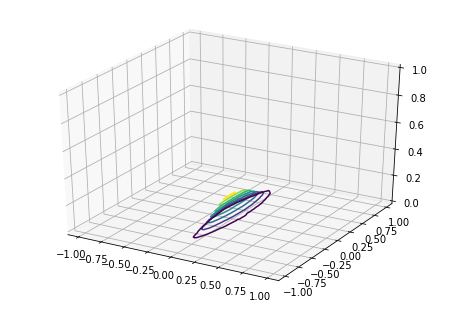

In [96]:
#Joint Distribution of X_0, X_4 for 4 noise

duration = 29.9
#fig, ax = plt.subplots()
fig = plt.figure()
ax = Axes3D(fig)
def make_frame(t):
    ax.clear()
    m = int(t * 10)
    ax.contour3D(bin_edges[1:], bin_edges[1:], stratified_mixed_hist[m])
    #ax.plot(bin_edges[1:], stratified_mixed_hist[m], 'o')
    ax.set_zlim(0.0, 1.0)
    #ax.set_ylim(0.0, 1.7)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.ipython_display(fps=10, loop=True, autoplay=True)